In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import false_discovery_control
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

In [2]:
# Creating data frame,
# Finding mean of Normal, NET and NEC per cdID,
# Compute difference of means between Normal, NET and NEC

In [3]:
superdf = pd.read_csv('RawmethLabel.txt', sep="\t").set_index('ID_REF').sort_index(axis=0)

lung = superdf.loc[:, superdf.columns.str.contains('lung')]
lungNormal = lung.loc[:, lung.columns.str.contains('normal')]
lungNET = lung.loc[:, lung.columns.str.contains('NET')]
lungNEC = lung.loc[:, lung.columns.str.contains('NEC')]

lung['Normal Mean'] = lungNormal.mean(axis=1)
lung['NET Mean'] = lungNET.mean(axis=1)
lung['NEC Mean'] = lungNEC.mean(axis=1)

lung['NET - Normal'] = lung['NET Mean'] - lung['Normal Mean']
lung['NEC - NET'] = lung['NEC Mean'] - lung['NET Mean']
lung['NEC - Normal'] = lung['NEC Mean'] - lung['Normal Mean']

lung

,lung.NET.normal.lung.G2.dead,lung.NET.tumor.lung.G2.alive,lung.NET.tumor.lung.G1.dead,lung.NEC.normal.lung.G3.alive,lung.NEC.tumor.lung.G3.alive,lung.NET.tumor.lung.G1.alive,lung.NET.tumor.lung.G1.alive.1,lung.NEC.tumor.lung.G3.dead,lung.NET.tumor.lung.G2.dead,lung.NEC.tumor.lung.G3.dead.1,...,lung.NET.tumor.lung.G1.alive.8,lung.NEC.tumor.lung.G3.alive.1,lung.NET.normal.lung.G1.alive.2,lung.NET.tumor.lung.G1.alive.9,Normal Mean,NET Mean,NEC Mean,NET - Normal,NEC - NET,NEC - Normal
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.252632,0.118557,0.292590,0.188126,0.204428,0.355056,0.298507,0.701537,0.515707,0.221531,...,0.207743,0.327089,0.249254,0.375635,0.212470,0.273400,0.317664,0.060930,0.044264,0.105194
cg00000103,0.382302,0.498315,0.571057,0.521426,0.278001,0.604637,0.366034,0.266367,0.557205,0.525196,...,0.366559,0.201589,0.573529,0.463415,0.429585,0.505253,0.409662,0.075669,-0.095591,-0.019923
cg00000109,0.879029,0.818562,0.616235,0.895753,0.800841,0.824190,0.842286,0.859246,0.848123,0.813490,...,0.897548,0.850541,0.838435,0.883433,0.772394,0.784889,0.813180,0.012496,0.028291,0.040787
cg00000155,0.795680,0.874509,0.864846,0.808661,0.865083,0.856842,0.916504,0.809534,0.785526,0.858464,...,0.911568,0.834013,0.872449,0.693587,0.840838,0.855226,0.850816,0.014388,-0.004410,0.009978
cg00000158,0.244875,0.058720,0.232019,0.807749,0.859097,0.857687,0.788328,0.113414,0.705564,0.299859,...,0.835505,0.177432,0.791825,0.466161,0.708317,0.660185,0.572179,-0.048131,-0.088007,-0.136138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.X.97129969R,0.154908,0.044629,0.043777,0.168939,0.055871,0.050412,0.052103,0.044868,0.150382,0.046326,...,0.050625,0.090379,0.099432,0.047317,0.089129,0.058018,0.065659,-0.031111,0.007641,-0.023470
ch.X.97133160R,0.190955,0.079392,0.129078,0.147584,0.043426,0.119980,0.154712,0.158541,0.177104,0.073205,...,0.111208,0.144453,0.159574,0.156574,0.139004,0.136576,0.107156,-0.002428,-0.029420,-0.031848
ch.X.97651759F,0.070126,0.079453,0.093648,0.140397,0.077972,0.103948,0.086302,0.099711,0.107859,0.065957,...,0.086325,0.088118,0.117351,0.082359,0.099033,0.083100,0.089041,-0.015932,0.005941,-0.009991


In [4]:
#KS test that takes in two samples eg. NET and Normal

In [5]:
def ks_test(sample1, sample2):
    results = []

    for cgid in sample1.index:
        if cgid in sample2.index:
            sample1VALUE = sample1.loc[cgid].values
            sample2VALUE = sample2.loc[cgid].values

            if len(sample1VALUE) > 0 and len(sample2VALUE) > 0:
                # Get KS statistic and p-value
                stat, pvalue = ks_2samp(sample1VALUE, sample2VALUE)
                results.append({'ID_REF': cgid, 'Pvalue': pvalue})

    
    output = pd.DataFrame(results).set_index('ID_REF')

    return output #[output['Pvalue'] <= .05] Filter Option

In [6]:
lungKSnetnormal = ks_test(lungNET, lungNormal)

lungKSnecnet = ks_test(lungNEC, lungNET)

lungKSnecnormal = ks_test(lungNEC, lungNormal)

lungKSnetnormal

,Pvalue
ID_REF,
cg00000029,0.453882
cg00000103,0.571327
cg00000109,0.887798
cg00000155,0.510071
cg00000158,0.346504
...,...
ch.X.97129969R,0.097639
ch.X.97133160R,0.971766
ch.X.97651759F,0.240920


In [7]:
#FDR test

In [8]:
FDRnetnormal = false_discovery_control(lungKSnetnormal['Pvalue'], method='bh')
lungKSnetnormal = lungKSnetnormal.rename(columns={'Pvalue': 'NET - Normal Pvalue'})
lungKSnetnormal['NET - Normal FDR'] = FDRnetnormal

FDRnecnet = false_discovery_control(lungKSnecnet['Pvalue'], method='bh')
lungKSnecnet = lungKSnecnet.rename(columns={'Pvalue': 'NEC - NET Pvalue'})
lungKSnecnet['NEC - NET FDR'] = FDRnecnet

FDRnecnormal = false_discovery_control(lungKSnecnormal['Pvalue'], method='bh')
lungKSnecnormal = lungKSnecnormal.rename(columns={'Pvalue': 'NEC - Normal Pvalue'})
lungKSnecnormal['NEC - Normal FDR'] = FDRnecnormal

In [9]:
# lung_filtered data frame 
# filtered by pvalue of cgID <= 0.05

In [10]:
lungKSnetnormal_filtered = lungKSnetnormal[lungKSnetnormal['NET - Normal Pvalue'] <= 0.05]
lungKSnecnet_filtered = lungKSnecnet[lungKSnecnet['NEC - NET Pvalue'] <= 0.05]
lungKSnecnormal_filtered = lungKSnecnormal[lungKSnecnormal['NEC - Normal Pvalue'] <= 0.05]

FDRnetnormal_filtered = false_discovery_control(lungKSnetnormal_filtered['NET - Normal Pvalue'], method='bh')
FDRnecnet_filtered = false_discovery_control(lungKSnecnet_filtered['NEC - NET Pvalue'], method='bh')
FDRnecnormal_filtered = false_discovery_control(lungKSnecnormal_filtered['NEC - Normal Pvalue'], method='bh')

lungKSnetnormal_filtered['NET - Normal FDR'] = FDRnetnormal_filtered
lungKSnecnet_filtered['NEC - NET FDR'] = FDRnecnet_filtered
lungKSnecnormal_filtered['NEC - Normal FDR'] = FDRnecnormal_filtered

lung_filtered = pd.concat([
    lung,
    lungKSnetnormal_filtered[['NET - Normal Pvalue']],
    lungKSnecnet_filtered[['NEC - NET Pvalue']],
    lungKSnecnormal_filtered[['NEC - Normal Pvalue']],
    lungKSnetnormal_filtered[['NET - Normal FDR']],
    lungKSnecnet_filtered[['NEC - NET FDR']],
    lungKSnecnormal_filtered[['NEC - Normal FDR']]
], axis=1, join='outer')

In [11]:
# Non filtered data frame

In [12]:
lung = pd.concat([
    lung,
    lungKSnetnormal[['NET - Normal Pvalue']],
    lungKSnecnet[['NEC - NET Pvalue']],
    lungKSnecnormal[['NEC - Normal Pvalue']],
    lungKSnetnormal[['NET - Normal FDR']],
    lungKSnecnet[['NEC - NET FDR']],
    lungKSnecnormal[['NEC - Normal FDR']]
], axis=1, join='outer')

lung 

,lung.NET.normal.lung.G2.dead,lung.NET.tumor.lung.G2.alive,lung.NET.tumor.lung.G1.dead,lung.NEC.normal.lung.G3.alive,lung.NEC.tumor.lung.G3.alive,lung.NET.tumor.lung.G1.alive,lung.NET.tumor.lung.G1.alive.1,lung.NEC.tumor.lung.G3.dead,lung.NET.tumor.lung.G2.dead,lung.NEC.tumor.lung.G3.dead.1,...,NEC Mean,NET - Normal,NEC - NET,NEC - Normal,NET - Normal Pvalue,NEC - NET Pvalue,NEC - Normal Pvalue,NET - Normal FDR,NEC - NET FDR,NEC - Normal FDR
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.252632,0.118557,0.292590,0.188126,0.204428,0.355056,0.298507,0.701537,0.515707,0.221531,...,0.317664,0.060930,0.044264,0.105194,0.453882,0.965998,0.382790,1.0,0.990936,1.0
cg00000103,0.382302,0.498315,0.571057,0.521426,0.278001,0.604637,0.366034,0.266367,0.557205,0.525196,...,0.409662,0.075669,-0.095591,-0.019923,0.571327,0.086611,0.992379,1.0,0.672483,1.0
cg00000109,0.879029,0.818562,0.616235,0.895753,0.800841,0.824190,0.842286,0.859246,0.848123,0.813490,...,0.813180,0.012496,0.028291,0.040787,0.887798,0.829987,0.518166,1.0,0.955411,1.0
cg00000155,0.795680,0.874509,0.864846,0.808661,0.865083,0.856842,0.916504,0.809534,0.785526,0.858464,...,0.850816,0.014388,-0.004410,0.009978,0.510071,0.630152,0.626591,1.0,0.904938,1.0
cg00000158,0.244875,0.058720,0.232019,0.807749,0.859097,0.857687,0.788328,0.113414,0.705564,0.299859,...,0.572179,-0.048131,-0.088007,-0.136138,0.346504,0.630152,0.572888,1.0,0.904938,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.X.97129969R,0.154908,0.044629,0.043777,0.168939,0.055871,0.050412,0.052103,0.044868,0.150382,0.046326,...,0.065659,-0.031111,0.007641,-0.023470,0.097639,0.630152,0.382790,1.0,0.904938,1.0
ch.X.97133160R,0.190955,0.079392,0.129078,0.147584,0.043426,0.119980,0.154712,0.158541,0.177104,0.073205,...,0.107156,-0.002428,-0.029420,-0.031848,0.971766,0.086611,0.382790,1.0,0.672483,1.0
ch.X.97651759F,0.070126,0.079453,0.093648,0.140397,0.077972,0.103948,0.086302,0.099711,0.107859,0.065957,...,0.089041,-0.015932,0.005941,-0.009991,0.240920,0.428730,0.626591,1.0,0.846290,1.0


In [13]:
# Color Chart 
# Normal Cell: green (#008000)
# Tumor Cell: red (#FF0000)
# Lung: pink (#FFC0CB)
# Gastropancreatic: orange (#FFA500)
# Alive: lightblue (#ADD8E6)
# Dead: purple (#800080)
# NET: #DA70D6 (hotpink)
# NEC: #483D8B (Dark Slate Blue)

In [14]:
# Boxplot of NET - Normal, NEC - NET and NEC - Normal

In [15]:
def boxplot(df, column, group_df=None, top_n=5, bottom_n=5, ylim=(0, 1.01), colors=None, title=None):
    if group_df is None:
        group_df = df
        
    if title is None:
        title = f'{column}'
    
    if colors is None:
        colors=["green", "#DA70D6", "#483D8B"]  # Normal, NET, NEC

    # Get the top and bottom CGs
    sorted_df = df.sort_values(by=column, ascending=False)
    top_cgs = sorted_df.index[:top_n].tolist()
    bottom_cgs = sorted_df.index[-bottom_n:][::-1].tolist()

    def classify_sample(sample_name):
        s = sample_name.lower()
        if '.normal.' in s:
            return 'Normal'
        elif '.net.' in s:
            return 'NET'
        elif '.nec.' in s:
            return 'NEC'
        return None

    def get_sample_groups(cg):
        sample_groups = {'Normal': [], 'NET': [], 'NEC': []}
        for sample in group_df.columns:
            group = classify_sample(sample)
            if group:
                value = group_df.at[cg, sample]
                sample_groups[group].append(value)
        return sample_groups

    def cg_details(cg, column):
        row = df.loc[cg]
        sample_counts = {'Normal': 0, 'NET': 0, 'NEC': 0}

        for sample in group_df.columns:
            group = classify_sample(sample)
            if group:
                sample_counts[group] += 1

        total = sum(sample_counts.values())
        lines = [
            f"Normal (N = {sample_counts['Normal']}), NET (N = {sample_counts['NET']}), NEC (N = {sample_counts['NEC']})"
        ]

        diff = row.get(column, np.nan)
        pval = row.get(f'{column} Pvalue', np.nan)
        fdr = row.get(f'{column} FDR', np.nan)
        stat_line = f"Difference = {diff:.2f}, Pvalue = {pval:.3g}, FDR = {fdr:.3g}"
        lines.append(stat_line)

        return '\n'.join(lines)

    def plot_cg(cg, rank, position=None):
        sample_groups = get_sample_groups(cg)
        data = [sample_groups['Normal'], sample_groups['NET'], sample_groups['NEC']]
        labels = ['Normal', 'NET', 'NEC']
        means = [np.mean(g) if g else 0 for g in data]

        plt.figure(figsize=(6, 4))
        box = plt.boxplot(data, patch_artist=True, labels=labels)

        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        # Annotate mean values
        for i, mean_val in enumerate(means, start=1):
            plt.text(i + 0.15, mean_val, f'{mean_val:.2f}', ha='left', va='center', fontsize=9)

        # Annotation text below title
        annotation_text = cg_details(cg, column)
        plt.title(f'{title}\n{position} {rank}: {cg}')
        plt.suptitle(annotation_text, fontsize=9, y=0.02)
        plt.ylim(ylim)
        plt.ylabel('Methylation Ratio')
        plt.show()

    # Top loop
    print("\nTop CGs:")
    for rank, cg in enumerate(top_cgs, start=1):
        plot_cg(cg, rank, position='Hypermethylation Biomarker')
    # Bottom Loop
    print("\nBottom CGs:")
    for rank, cg in enumerate(bottom_cgs, start=1):
        plot_cg(cg, rank, position='Hypomethylation Biomarker')



Top CGs:


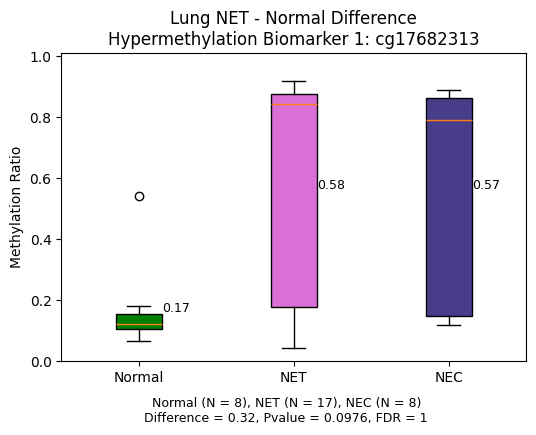

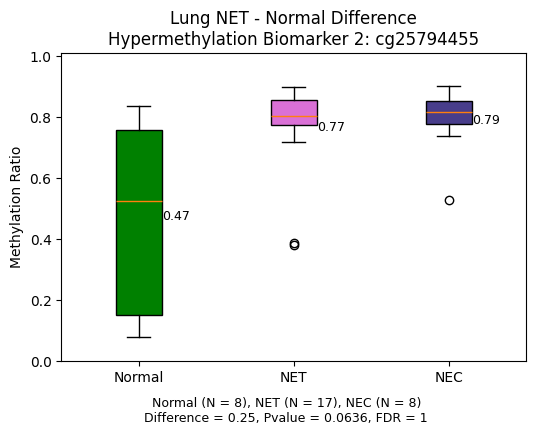

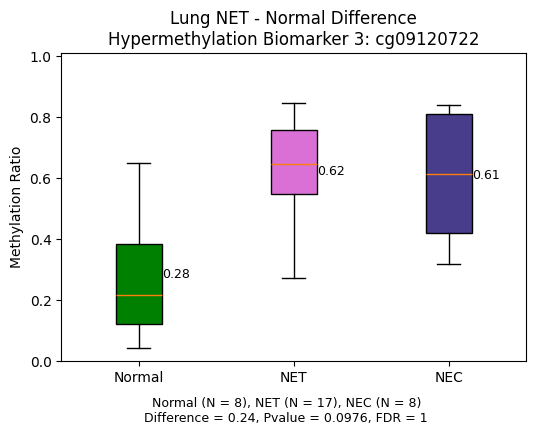

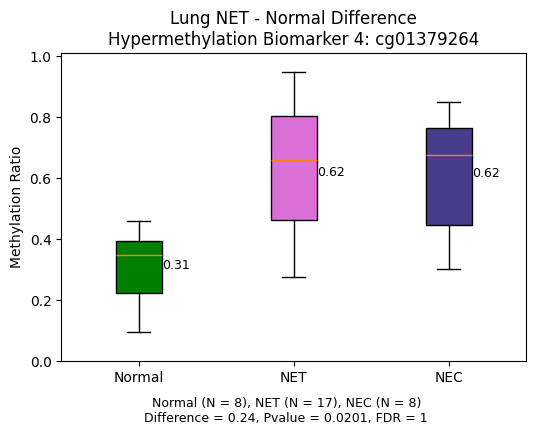

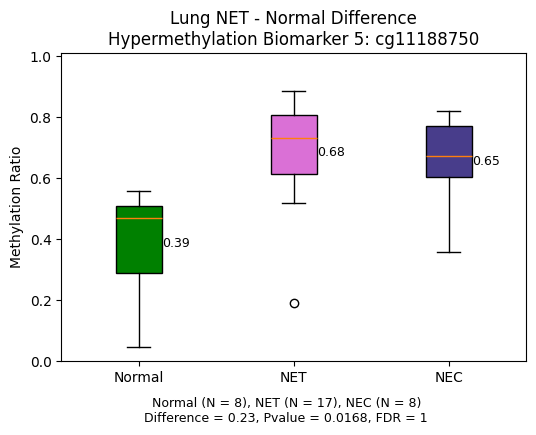


Bottom CGs:


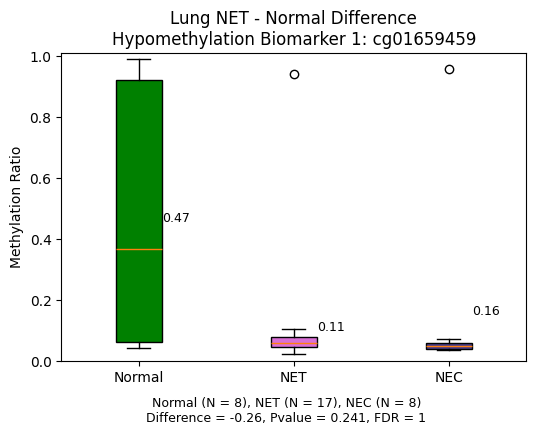

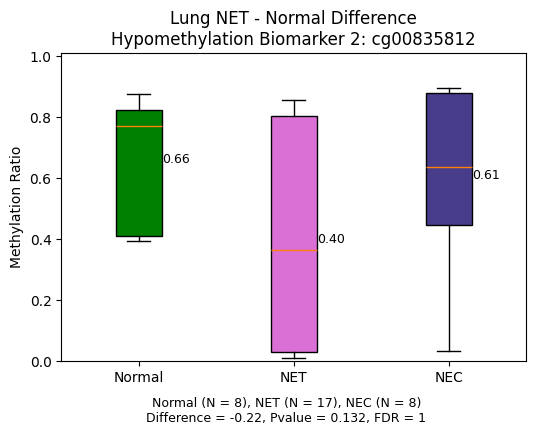

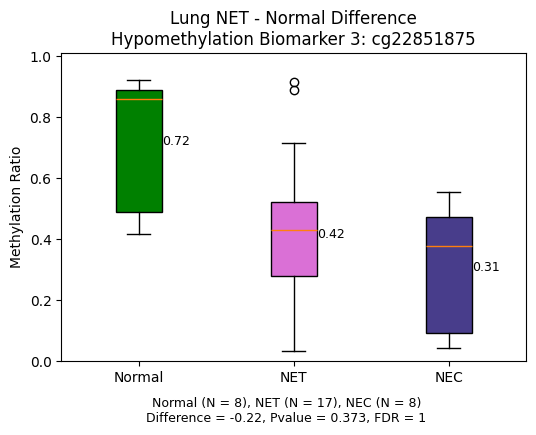

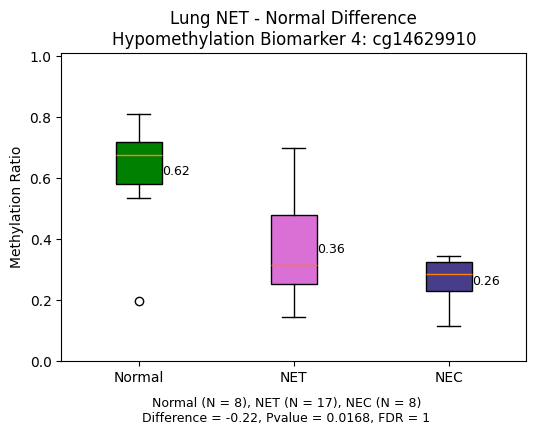

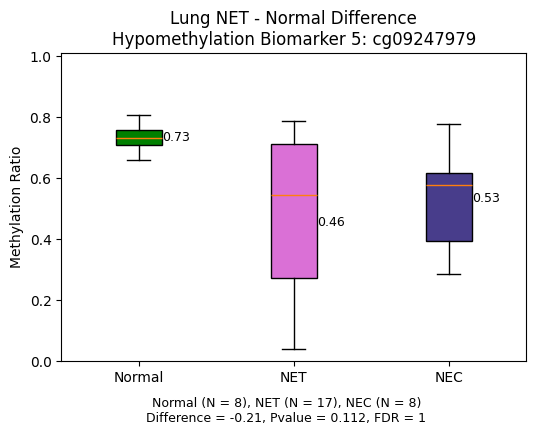


Top CGs:


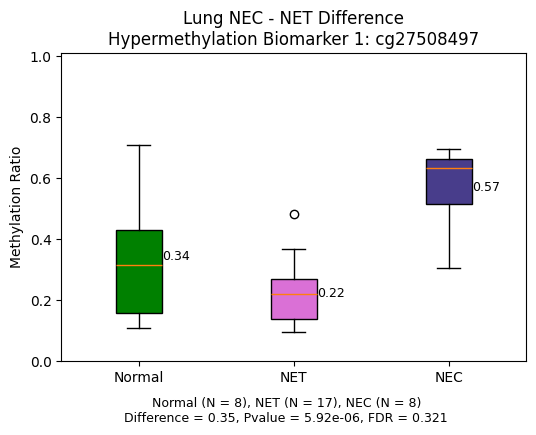

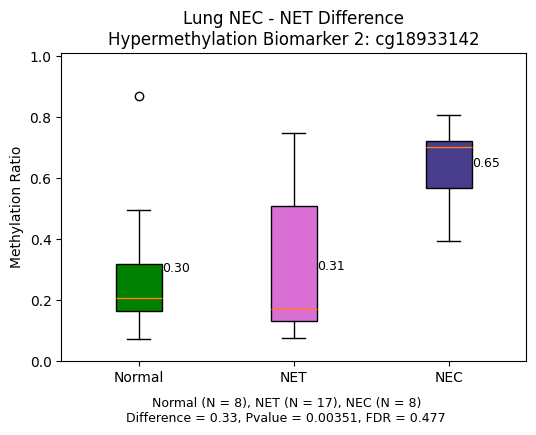

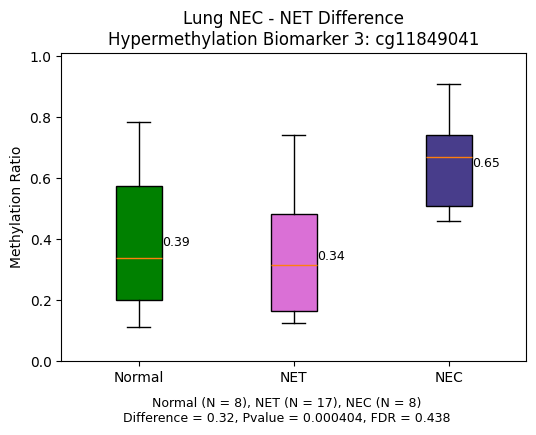

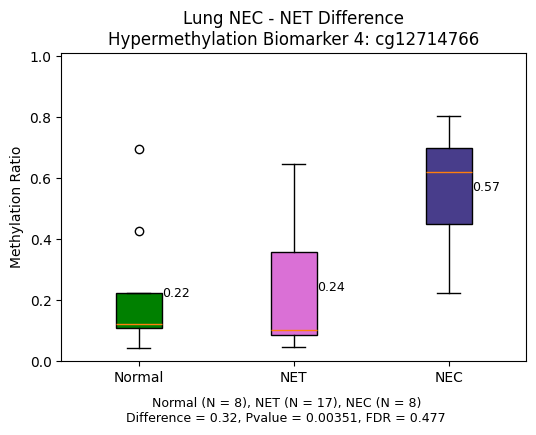

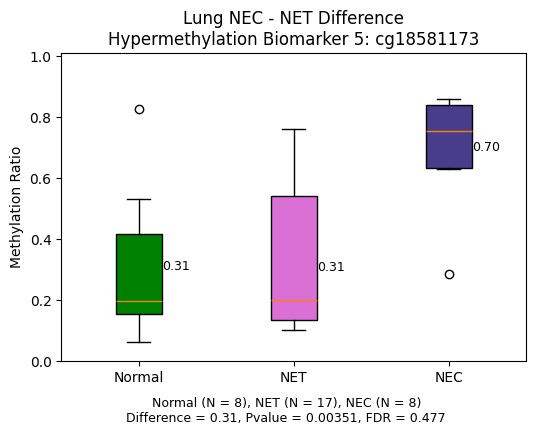


Bottom CGs:


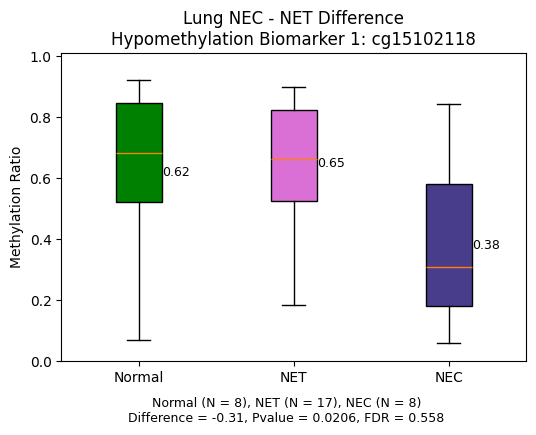

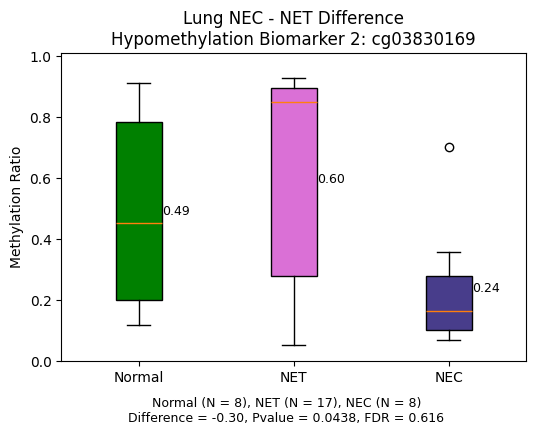

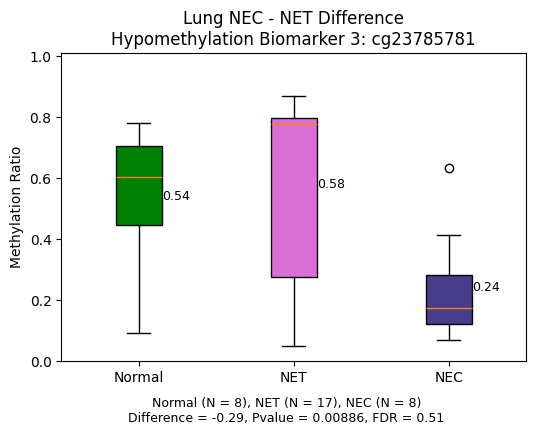

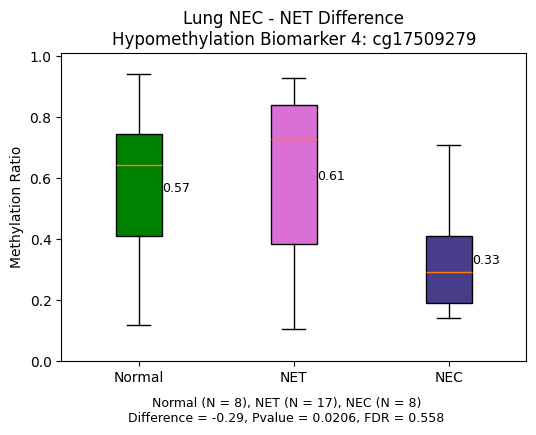

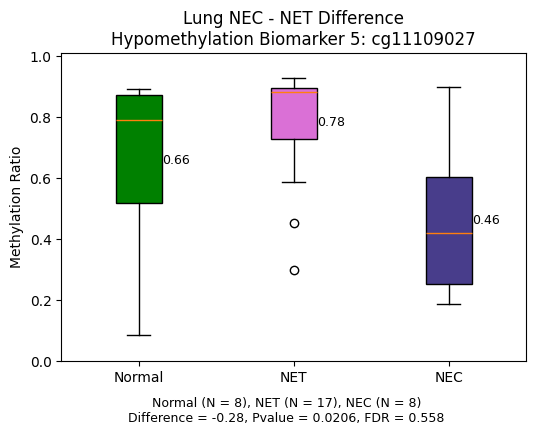


Top CGs:


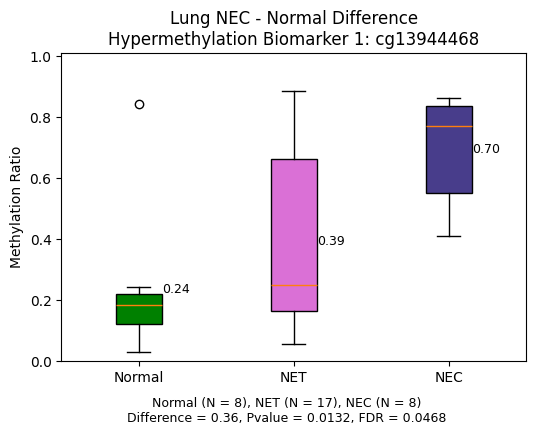

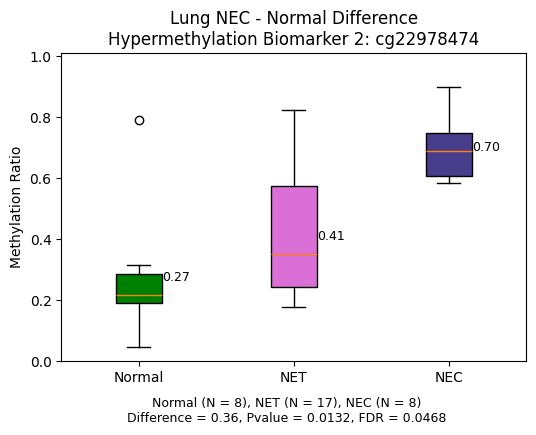

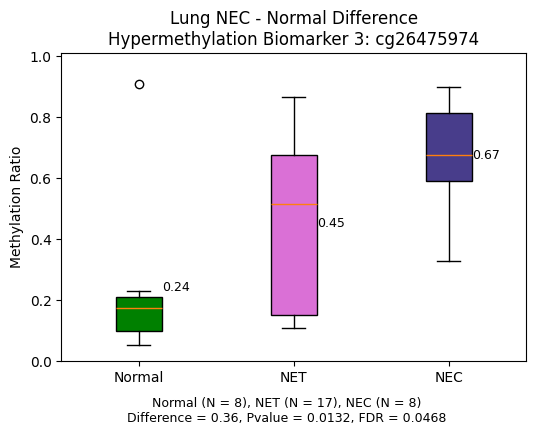

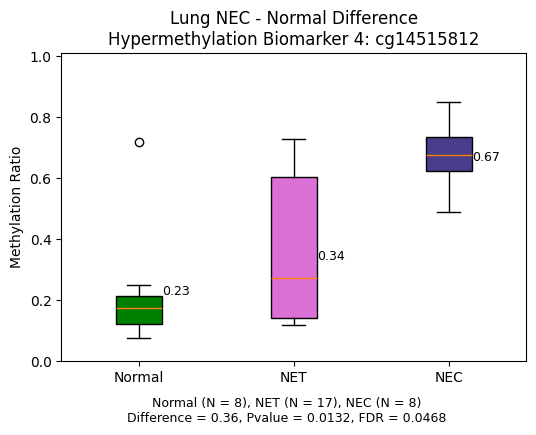

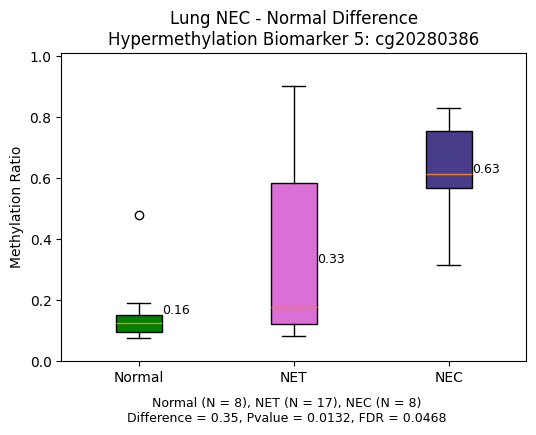


Bottom CGs:


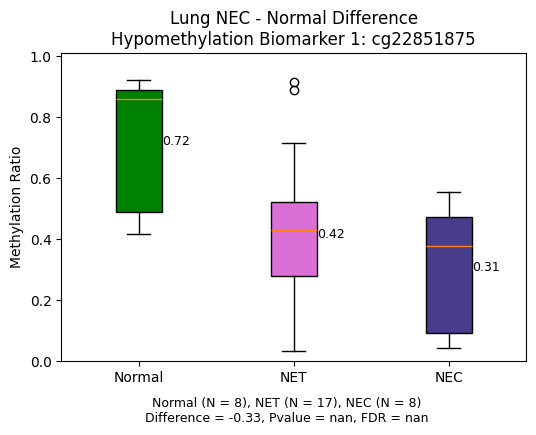

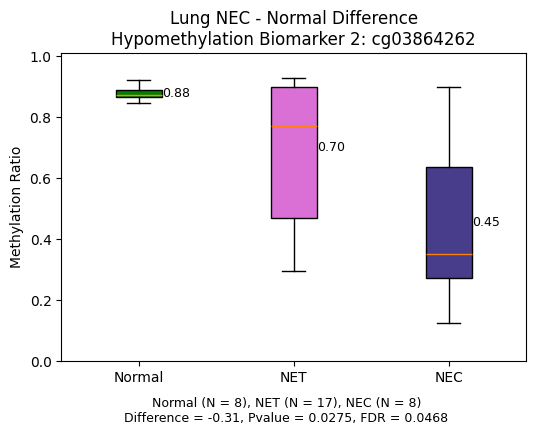

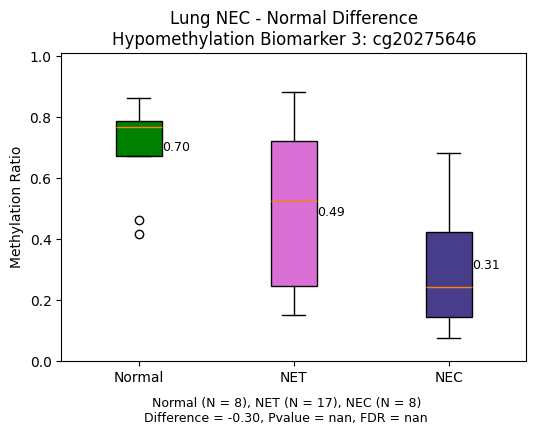

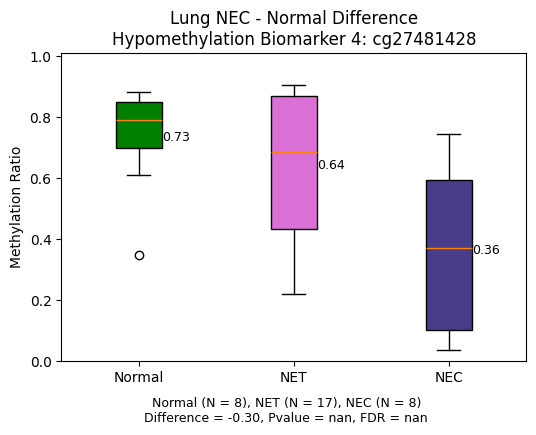

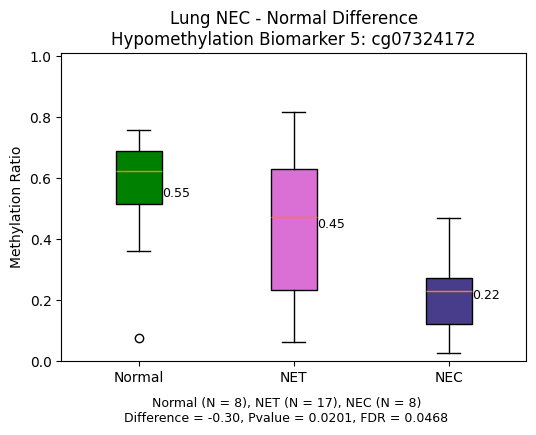

In [16]:
boxplot(
    df=lung,                          
    column='NET - Normal',            
    title='Lung NET - Normal Difference'
)

boxplot(
    df=lung,                          
    column='NEC - NET',                
    title='Lung NEC - NET Difference'
)

boxplot(
    df=lung_filtered,                          
    column='NEC - Normal',             
    title='Lung NEC - Normal Difference'
)


In [18]:
# Reusable function to extract cell type from sample names

def extract_features(sample):

    sample = sample.lower()
    celltype = "Normal" if ".normal." in sample else "NET" if ".net." in sample else "NEC" if ".nec." in sample else "Unknown"

    return celltype

celltypes = superdfT.index.to_series().apply(extract_features)

custom_palette = {
    'Normal': 'green',
    'NET': '#DA70D6',
    'NEC': '#483D8B'
}

In [19]:
#PCA

In [29]:
pca = PCA(n_components=2)
superdf_pca = pca.fit_transform(superdf.T)

pca_df = pd.DataFrame(superdf_pca, columns=['PCA1', 'PCA2'], index=superdf.T.index).assign(CellType=celltypes.values)

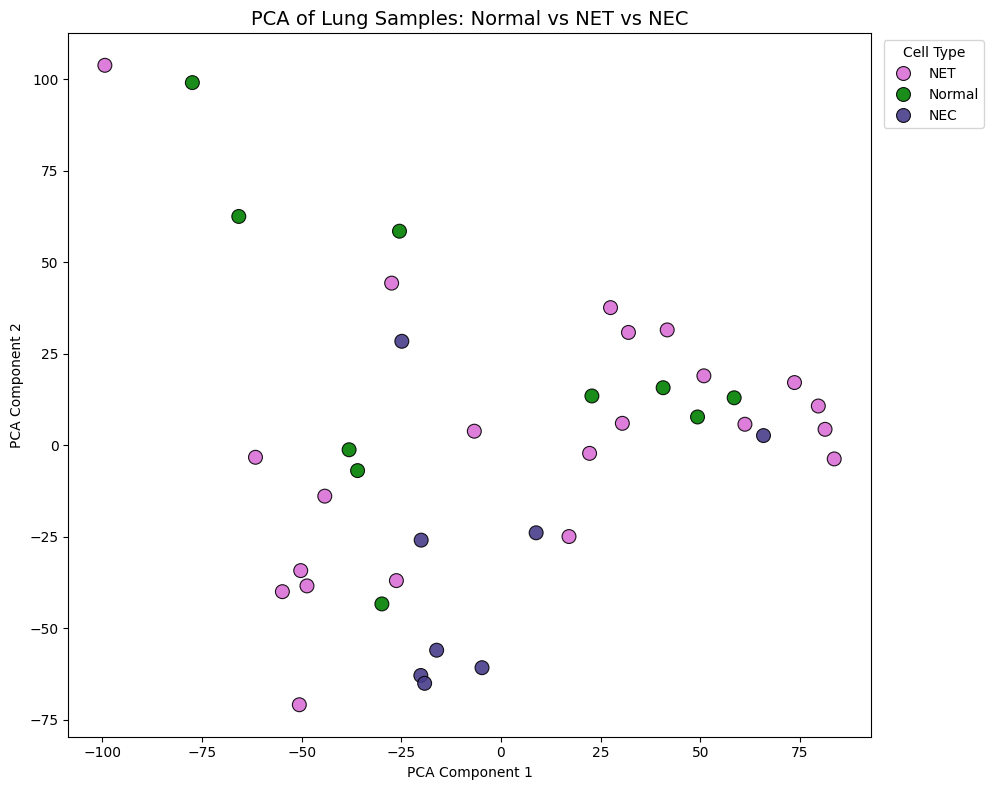

In [30]:
custom_palette = {
    'Normal': 'green',
    'NET': '#DA70D6',
    'NEC': '#483D8B'
}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df,
    x='PCA1',
    y='PCA2',
    hue='CellType',
    palette=custom_palette,
    s=100,
    alpha=0.9,
    edgecolor='black'
)

plt.title('PCA of Lung Samples: Normal vs NET vs NEC', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cell Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.tight_layout()
plt.show()


In [22]:
#UMAP

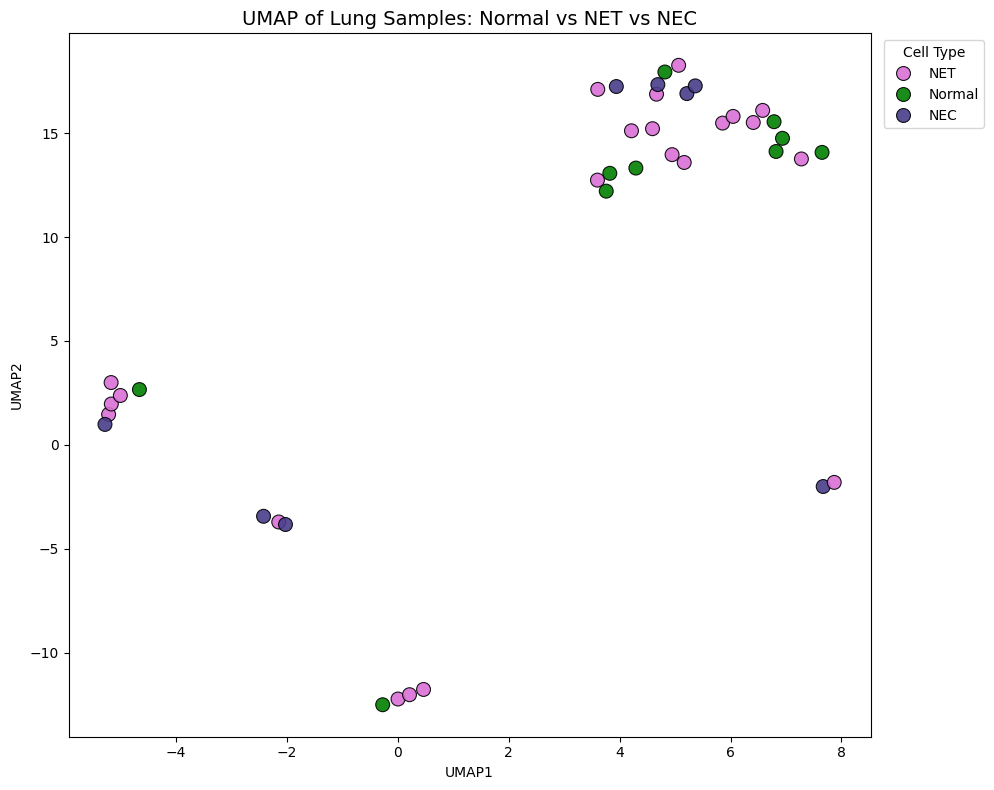

In [28]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.4, n_components=2)
embedding_umap = reducer.fit_transform(superdf.T)

umap_df = pd.DataFrame(embedding_umap, columns=['UMAP1', 'UMAP2'], index=superdf.T.index)
umap_df['CellType'] = celltypes.values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_df,
    x='UMAP1',
    y='UMAP2',
    hue='CellType',
    palette=custom_palette,
    s=100,
    alpha=0.9,
    edgecolor='black'
)
plt.title('UMAP of Lung Samples: Normal vs NET vs NEC', fontsize=14)
plt.legend(title='Cell Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.tight_layout()
plt.show()


In [24]:
#TSNE

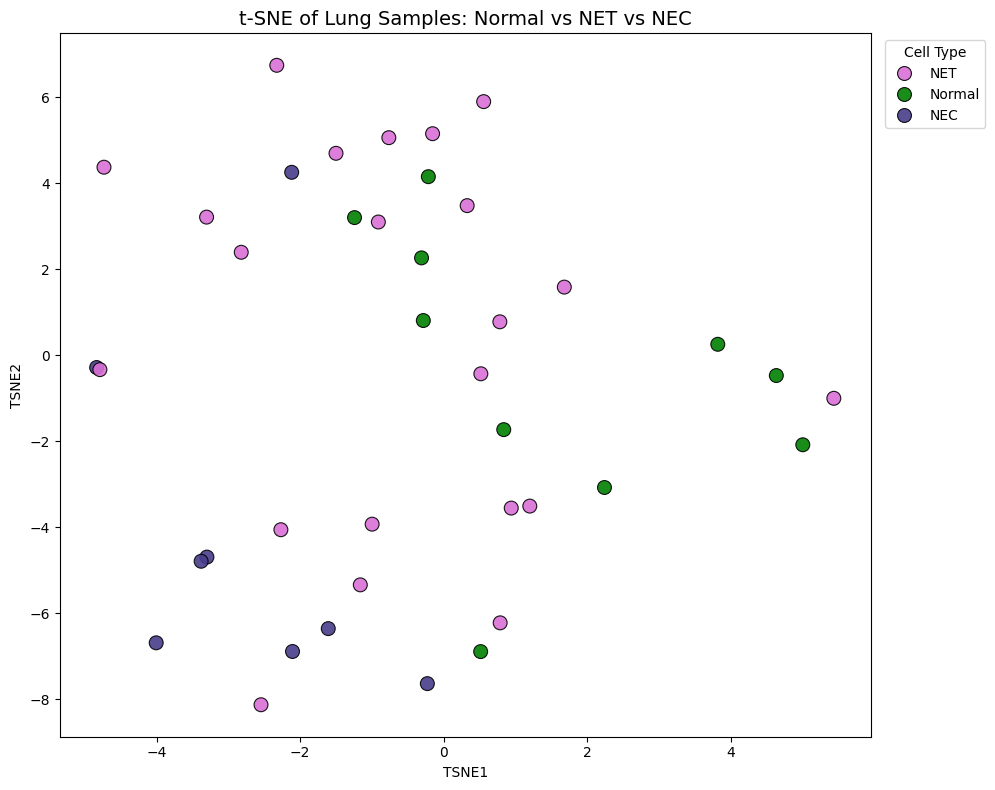

In [27]:
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embedding_tsne = tsne.fit_transform(superdf.T)

tsne_df = pd.DataFrame(embedding_tsne, columns=['TSNE1', 'TSNE2'], index=superdf.T.index)
tsne_df['CellType'] = celltypes.values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x='TSNE1',
    y='TSNE2',
    hue='CellType',
    palette=custom_palette,
    s=100,
    alpha=0.9,
    edgecolor='black'
)
plt.title('t-SNE of Lung Samples: Normal vs NET vs NEC', fontsize=14)
plt.legend(title='Cell Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.tight_layout()
plt.show()
